In [1]:
# EXECUTE FIRST

# computational imports
import numpy as np
import pandas as pd

from scipy.optimize import minimize
import json
from simanneal import Annealer
# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
# for reading files from urls
import urllib.request
# display importt
from IPython.display import display, IFrame
from IPython.core.display import HTML

# for playing videos, customize height and width if desired
def play_video(vid_name, w = 640, h = 360):
    vid_path = "https://media.uwex.edu/content/ds/ds775_r19/"
    return IFrame( vid_path + vid_name + "/index.html", width = w, height = h )

# import notebook styling for tables and width etc.
response = urllib.request.urlopen('https://raw.githubusercontent.com/DataScienceUWL/DS775v2/master/ds755.css')
HTML(response.read().decode("utf-8"));

# for this notebook we get rid of a bunch of warnings that don't hurt anything
import warnings
warnings.filterwarnings('ignore')

***Note:  this is a new version of Lesson 5 that we wrote in Summer 2020.  Please fire away with questions on Piazza as we know the first draft of anything often needs clarification!***

# Global Optimization

The goal of global optimization is to find the global optimimum value which means we want to identify the best possible soluiton in the entire search space.  However for many problems the search space is too large and/or the function landscape is too complicated to guarantee that the best solution can be found.

A metaheuristic algorithm attempts to find a good solution without any guarantee of being able to find the best solution.  Often metaheuristics are stochastic in nature, that is they incorporate randomness as an element of the search, but they aren't generally completely random in nature.  They often incorporate search patterns which are known to work well for the problem at hand.

Metaheuristic algorithms try to find a compromise somewhere between randomly searching the search space and local search.  People often speak of the **exploration and exploitation tradeoff**.  Exploration ensures the algorithm reaches different promising regions of the search space, whereas exploitation ensures the searching of optimal solutions within the given region.  The trick is in finding the right balance. Go too far into exploitation and the algorithm gets stuck in local extrema, go too far to exploration and the algorithm will waste time on solutions that are less likely to be good and ignore the information already gathered.

Unfortunately there is no single algorithm which works best for all classes of problems.  This is often referred to as a "no free lunch theorem" in optimization.  We'll focus on the two stochastic optimization algorithms that are described in your textbook:  simulated annealing and genetic algorithms.

# Simulated Annealing

Think of simulated annealing as an enhanced local search that allows some moves that don't improve the best function value to try to climb

In a hill-climbing local search we only allow moves that increase the objective function value.  

Here is our pseudo-code from the previous lesson for **Local Search:**
```
 set starting state 
 while local_condition 
     select a move 
     if acceptable 
         do the move 
         if new optimum 
             remember it 
 endwhile 
 ```

Simulated annealing is a trajectory based method for generating a sequence of solutions and is similar our basic "hill-climbing" local search algorithm.  In a strict hill-climbing algorithm we only allow uphill moves, but in simulated move we sometimes allow downhill moves and are more likely to allow downhill moves in the early part of the search.  The idea is that to find the tallest peak in a mountain range we have to first descend from a lower peak.

The probability of a downhill move is determined by a temperature parameter that decreases throughout the search.  The probability of a downhill move depends on the size of the downhill move compared to the temperature.  At high temperatures large and small downhill moves are probable, but as the temperature decreases only small downhill moves are probable so that the search performs similarly to a local search at low temperatures

In simulated annealing algorithm high temperature promotes exploration (global search) while low temperature promote exploitation (local search).  As the algorithm proceeds the temperature decreases and transitions from exploration to exploitation.

Here is pseudo-code for **Simulated Annealing:**
```
 set starting state and initial temperature
 while local_condition 
     select a move 
     if acceptable 
         do the move 
         if new optimum or random # < probability determined by temperature
             remember it
     decrease temperature
 endwhile 
 ```
 
Choosing the initial temperature and the manner in which the temperature decreases are critical to the performance of simulated annealing.  We'll start with a temperature schedule that looks like this:
$$ T = T_0 \alpha^n.$$
Where $T_0$ is the initial temperature, $0 < \alpha < 1,$ and $n$ is the number of iterations.   This is called geometric temperature decay, but many other choices are possible.  In the next section we'll demonstrate simulated annealing for the traveling salesman problem.



In the next section we present simulated annealing using our own code so that you can see how it works, but in general we'll use the `simanneal` package that will be introduced further below.

## Simulated Annealing with TSP (video)

We'll use the seven city example TSP from the textbook. Find the shortest tour (or cheapest cost) to visit all 7 cities and return to the starting city in the following graph:

<img src="./images/HillierTSP.png" width=400>

We'll store all of the intercity distances in a two dimensional list that we call distance_matrix. For cities that aren't connected we'll use the "bigM" method and introduce a distance of 100 between those pairs of cities so that those routes won't be included in the tour. Note that the picture labels the cities 1 through 7, but in Python we'll use 0 through 6.  The data is stored in the included json file.

If you want to really understand how simulated annealing worksThe following video includes a walkthrough of the code below.

In [2]:
# execute this cell for video
play_video("ds775_lesson5_simulated-anneal-tsp")

In [3]:
# import numpy as np
# import json
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("darkgrid")

# load data (this may have to be adapted for different problems)
with open("data/HillierTSP.json", "r") as tsp_data:
    tsp = json.load(tsp_data)
distance_matrix = tsp["DistanceMatrix"]
individual_size = tsp["TourSize"]

# define objective function
def tour_distance(individual, dist_mat):
    distance = dist_mat[individual[-1]][individual[0]]
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += dist_mat[gene1][gene2]
    return distance

def sub_tour_reversal(tour):
    # reverse a random tour segment
    num_cities = len(tour)
    i, j = np.sort(np.random.choice(num_cities, 2, replace=False))
    return np.concatenate((tour[0:i], tour[j:-num_cities + i - 1:-1],
                              tour[j + 1:num_cities]))

# Random Number Seed
# if you want reproducible results, then uncomment the following line
# and play with the seed value until you get a result you like. If you run 
# it again with the same value, then you'll get the same result.
# np.random.seed(123)

def simanneal_tsp(init_state, dist_mat, max_no_improve, init_temp, alpha): ###
    '''
    We use state to refer to the values of the input variable(s) for the objective function.
    For the TSP problem, the state is a tour of the cities.
    We use obj to refer to the objective function value.
    For the TSP problem, obj is the total distance of the tour.
    
    To adapt this for another minimization problem, 
    only the lines with tour_distance and sub_tour_reversal need to change 
    to give a different objective function and a different move function.
    Additional arguments to the objective function should be passed into the search function
    similar to how we passed in dist_mat abov
    '''

    curr_state = init_state
    curr_obj = tour_distance(curr_state, dist_mat)
    best_state = curr_state  ###
    best_obj = curr_obj  ###

    # stop search if no better state is found within max_no_improve iterations
    num_moves_no_improve = 0
    iterations = 0
    temp = init_temp

    # save history for plotting after optimization
    history = np.array([[iterations, curr_obj, best_obj]])  ###

    while (num_moves_no_improve < max_no_improve):
        num_moves_no_improve += 1
        iterations += 1  # just for tracking
        new_state = sub_tour_reversal(curr_state) # make a move
        new_obj = tour_distance(new_state, dist_mat)
        delta = curr_obj - new_obj ###
        prob = np.exp(min(delta, 0) / temp) ### # compute prob accept uphill move

        if new_obj < curr_obj or np.random.uniform() < prob : ### # accept if decrease or rand < prob
            curr_state = new_state
            curr_obj = new_obj
            if curr_obj < best_obj: ### # keep track of best ever
                best_state = curr_state ###
                best_obj = curr_obj ###
                num_moves_no_improve = 0 ###

        temp *= alpha ###

        history = np.vstack( (history, np.array([[iterations,curr_obj,best_obj]]) ) ) ###

    return best_state, best_obj, iterations, history

# apply the simanneal_tsp() function to our seven city problem
num_cities = len(distance_matrix)
init_tour = np.random.permutation(np.arange(num_cities))

best_tour, best_dist, iterations, history = simanneal_tsp(init_tour, distance_matrix, 200, 100, .995)
best_dist

63

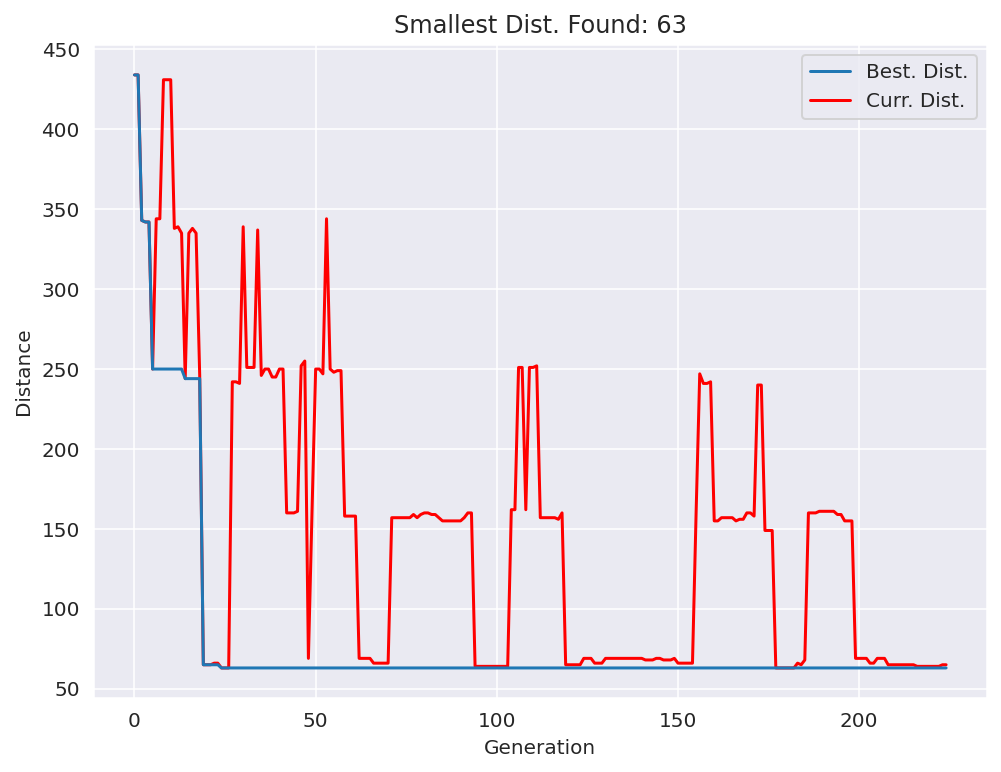

In [4]:
# plot the progress of the search for visualization
# it isn't necessary to do this in the homework, but you're welcome to do so

fig = plt.figure(figsize=(8, 6))
line_min, = plt.plot(history[:,0], history[:,1], label='Curr. Dist.',color='red')
line_curr, = plt.plot(history[:,0],history[:,2], label='Best. Dist.')
plt.xlabel('Generation')
plt.ylabel('Distance')
plt.legend(handles=[line_curr, line_min])
plt.title('Smallest Dist. Found: {:d}'.format(int(best_dist)));

### *Self Assessment: Simulated Annealing for Gerrymandering*

Copy the gerrymandering code from Lesson 4 and adapt the simulated annealing code above to try to find a solution in which republicans win 9 of the 10 districts.  Beware that you're trying to maximize the fitness.  The simplest way to use a minimization algorithm to maximize is to negate the fitness value.  If you start with simanneal_tsp then you should need only minor changes.

You'll have to change the values of the initial temperature, max_no_improve, and alpha.  The positive initial temperature should be similar to the initial fitness values (in magnitude).  Increasing max_no_improve allows the search to explore for longer.  Increasing alpha means the temperature doesn't decrease as quickly so that more uphill moves are allowed and the algorithm can explore more of the search space.

## Using the `simanneal` package (video)

The `simanneal` package is pretty straightforward to use. Using the simanneal package has a couple of advantages over our version of simulated annealing above.  First, we don't have to worry about the algorithm framework.  Second, we don't have to worry about figuring out a temperature schedule.  While it's possible to specify a temperature schedule, it is far easier to use the `auto` scheduler and specify the approximate amount of time we'd like to wait for a solution

The package works by making an object of the Annealer class and then calling the anneal method on that object. To set up a problem we have to set three things in our instance of the Annealer class.

1.  the state initializer 
2.  the move function that tells the anneal how to generate new moves
3.  the fitness function (fitness is called energy in this package and it was called objective in the locsearch package in Lesson 4).

The anneal method appears to always find minima so you may have to negate your function if you want to find a maximum. The <a href="https://github.com/perrygeo/simanneal">Github page</a> has some short documentation about the simanneal package.

The next cell is walkthrough of the code below.

In [5]:
# execute this cell for video
play_video("ds775_lesson5_simanneal-package-on-tsp")

In [6]:
# relies on data loaded in previous section

# import numpy as np
# from simanneal import Annealer

def tour_distance(tour, dist_mat):
    distance = dist_mat[tour[-1]][tour[0]]
    for gene1, gene2 in zip(tour[0:-1], tour[1:]):
        distance += dist_mat[gene1][gene2]
    return distance

def sub_tour_reversal(tour):
    # reverse a random tour segment
    num_cities = len(tour)
    i, j = np.sort(np.random.choice(num_cities, 2, replace=False))
    return np.concatenate((tour[0:i], tour[j:-num_cities + i - 1:-1],
                              tour[j + 1:num_cities]))
class TravellingSalesmanProblem(Annealer):

    # pass extra data (the distance matrix) into the constructor
    def __init__(self, state, distance_matrix):
        self.distance_matrix = distance_matrix
        super(TravellingSalesmanProblem, self).__init__(state)  # important!

    def move(self):
        self.state = sub_tour_reversal(self.state)

    def energy(self):
        return tour_distance(self.state, self.distance_matrix)

# load data (this may have to be adapted for different problems)
with open("data/HillierTSP.json", "r") as tsp_data:
    tsp = json.load(tsp_data)
distance_matrix = tsp["DistanceMatrix"]
init_tour = np.random.permutation(np.arange(len(distance_matrix))).astype(int).tolist()

tsp = TravellingSalesmanProblem(init_tour, distance_matrix)
tsp.set_schedule(tsp.auto(minutes=.2)) #set approximate time to find results

best_tour, best_dist = tsp.anneal()

best_dist

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


 Temperature        Energy    Accept   Improve     Elapsed   Remaining


63

### *Self Assessment: Simulated Annealing for Gerrymandering with `simanneal`*

Use the `simanneal` package to try to find a solution in which republicans win 9 of the 10 districts.  Beware that you're trying to maximize the fitness so you'll either need to use a negated fitness function.  You'll also have to set the cities data frame in the initializer (similar to the distance matrix in the tsp above).  The set up here is very similar to using the `locsearch` package to solve the gerrymandering problem as we did in the last self-assessment in Lesson 4.

If you're using the auto option for the temperature schedule then it could take several minutes to complete a run because the search space for this problem is huge.  Each entry in the 18 dimensional vector can be a number 0 through 9 so there are $10^{18}$ possible vectors to explore.  Alternately you can manually set the temperature schedule with something like this:

```
tsp.Tmax = 5000
tsp.Tmin = 2.5
tsp.steps = 5000
tsp.updates = 100
```

You should replace tsp with the appropriate name that you setup in your code and also experiment with the numbers.  Make sure to comment out the auto schedule.  

## Simulated Annealing for Continuous Optimization

Simulated annealing was designed for combinatorial (discrete) optimization problems, but has been adapted to continuous optimization problems.  The main issue is how to generate a new move at each iteration.  There are many variations, but often the move is selected at random from a suitable probability distribution such as a normal or uniform distribution.

The objective functions we consider here aren't from real applications, instead they're chosen to give you an idea how the algorithm works for difficult optimization problems with many local optima.  It's good to have this sort of thing in mind when, for instance, you're trying to train a complicated neural network and have to optimize the weights in the network to find the best fit to your data.

### A non-convex 2D example

We found this two-dimensional example in <a href="http://apmonitor.com/me575/index.php/Main/SimulatedAnnealing">this tutorial</a> on simulated annealing.

Find the minimum value of 
$$f(x,y) = 0.2 + x^2 + y^2 - 0.1 \cos(6 \pi x) - 0.1 \cos(6 \pi y)$$ 

for $-1 \leq x,y \leq 1$.  This function is similar to the Rastrigin function and the global minimum value is $f(0,0) = 0$.  A contour plot, shown below, illustrates that there are many local minima (in the center of many of the small loops, some correspond to local maxima).  The <a href = "http://apmonitor.com/me575/index.php/Main/SimulatedAnnealing">tutorial</a> itself is worthy of a look and has a nice flow chart outlining how simulated annealing works.

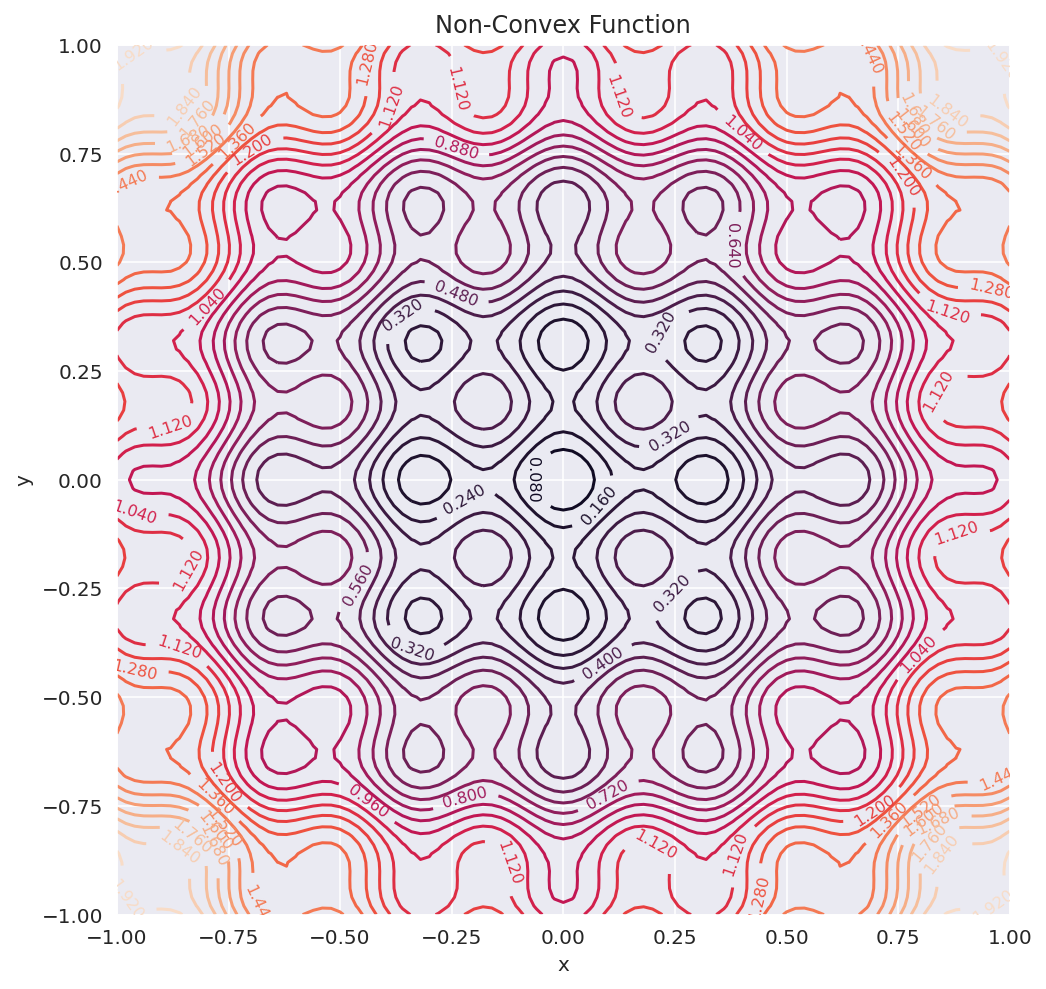

In [7]:
# define objective function and show a contour plot

def f(xy):
    obj = 0.2 + sum(xy**2 - 0.1*np.cos(6*np.pi*xy))
    return obj

# we could have written the objective function like this for transparency:
# if the argument is a list with [ numpy array of x's, numpy array of y's]
# def f(xy):
#     x = xy[0]
#     y = xy[1]
#     obj = 0.2 + x**2 + y**2 - 0.1*np.cos(6*np.pi*x) - 0.1*np.cos(6*np.pi*y)
#     return obj

# see script for details of plot
%run scripts/bumpy_contours.py

Here is a 3D plot that makes it easier to see all of the local minima in the search space.  A local search will easily get stuck in the wrong minimum if the initial search point isn't very close to the origin.

In [8]:
%run scripts/bumpy_2d.py

To use simulated annealing to optimize a function with continuous variables isn't all that different than how we used it to find a good, or even optimal, tour in the traveling salesman problem.  

We're going to rely on the `simanneal package` in the rest of this lesson because it's much more robust than our "homebrewed" code in the `simanneal_tsp()` function above. 
To use the package we'll have to generate an initial state, define the `energy()` method for returning the objective function value, and define the `move()` method for making a move from a current state to a new state.

To generate an initial state you could select uniformly distributed random numbers between -1 and 1:
```
init_state = np.random.uniform(low=-1, high=1, size=2)
```

We like to write functions for computing the objective function value and for making moves and then call those functions from the `move()` and `energy()` methods in the class definition for our problem as we did in the simanneal package TSP example above.

We already have the objective function from where we made the contour plot:
```
def f(xy):
    obj = 0.2 + sum(xy**2 - 0.1*np.cos(6*np.pi*xy))
    return obj
```

Making a move will consist of applying two functions successively.  The first function adds normally distributed random numbers to each variable while the second function clips values that are out of the $[-1,1]$ bounds.  The scale of the move will need to be passed to the first function, while the values of the lower and upper bounds need to be passed to the clipping function.  These values will need to be initialized in the `__init__` constructor similar to how we worked with the distance matrix in the TSP example.  Here are the functions:
```
def gauss_move(xy,sigma):
    # xy is a 1 by dim numpy array
    # sigma is the standard deviation for the normal distribution
    dim = len(xy)
    return xy + np.random.normal(loc = 0, scale = sigma, size=dim)

def clip_to_bounds(xy,low,high):
    # xy is a 1 by dim numpy array
    # low is the lower bound for clipping variables
    # high is the upper bound for clipping variables
    return np.array( [min(high,max(low,v)) for v in xy])
```

#### *Self-Assessment for Simulated Annealing with Continuous Variables*

Use the objective and move functions from above to create a class using the `simanneal` package.  Use it to approximate the location of the global minimum for the "Bumpy" function above.  You'll notice that you usually will get close to the location of the global minimum at the origin, but it won't be exact because it is very difficult to randomly move exactly to the minimum location.  Usually, for continuous functions simulated annealing is combined with local search in an iterative procedure (we'll see an example of this in the homework with the `dual_annealing` optimizer from the `scipy.optimize` package.  For this example you could take the best state found by simulated annealing and use it to start a local search using `minimize` from `scipy.optimize` package.

The code from the TSP example above is a good starting point.  Instead of the distance matrix you'll need to pass the scale parameter sigma to determine the size of the moves.  A good starting point for sigma is range/6 where range = upper bound - lower bound.  This value for sigma is because a normal distribution is about 6 * sigma wide.  You may want to experiment with the value of sigma to see how it effects the result of simulated annealing.  You could also play with the time allowed when you set the schedule for the annealing.

# Genetic Algorithms

Think of a genetic algorithm as a smart version of random search.  Genetic algorithms are great at exploring large search spaces but sometimes aren't so good at zeroing in on a solution once they've gotten close to a good solution.

You should have read about the basics of genetic algorithms in the textbook.  Genetic algorithms are a vast subject and we'll just scratch the surface.  Fortunately there seem to be tons of free tutorials and other resources available for learning more about genetic algorithms.  The pseudocode for a genetic algorithm is as follows:
```
generate the initial population
compute fitness
repeat
    selection
    crossover
    mutation
    compute fitness
until population has converged
```

Here are just a few notes about the algorithm:
* population = set of trial solutions that are also called individuals (or chromosomes)
* fitness = objective function
* selection = choosing the most promising solutions in the current population but leaving a few bad ones for diversity
* crossover = combining or breeding the selected solutions to generate new candidate solutions
* mutation = randomly tweaking some of the solutions in the current population to encourage exploration of the solution space

In terms of the **exploration and exploitation tradeoff** one can think of selection as being exploitation (local search) and crossover and mutation as being exploration (global search).  Changing the parameters used in selection, crossover, and mutation changes the balance between exploration and exploitation.


We will write our own genetic algorithms so that we can get a better understanding of their ingredients.  Before we dive into the details we summarize some packages you could explore to apply genetic algorithms to your optimization problems.

## Genetic Algorithm Packages

If you need to use genetic algorithms in practice, it's probably better to seak out a package that has that functionality.  Some options include:
* <a href="https://github.com/deap/deap" target="_blank">The DEAP package</a>.  This package is for genetic programming.  It's very powerful and flexible, but also abstract with a significant learning curve.  It's worth learning if you often need to use genetic algorithms or other types of evolutionary algorithms.
* <a href="https://pypi.org/project/geneticalgorithm/" target="_blank">The geneticalgorithm package</a> This package is an easy to use, but limited, genetic algorithm for minimization.  It supports either real or integer variables.  It can't be used for problems with permuations such as TSP.  Also the objective function can have only one argument so if you need additional data (e.g. the distance matrix) the function will have to find the data in the global scope.  It's slow with the default settings.
* The `deap_wrapper` package.  This is something we've been working on but at the moment it's not a well documented package.  If you're curious you can see examples of how to use it in the notebook `deap_wrapper_examples.ipynb` in the same folder as this lesson.
* The `GA` package in R.  This is a really easy to use implementation of the genetic algorithms that handles several types of variables.  Documentation is <a href="https://cran.r-project.org/web/packages/GA/" target="_blank">here on CRAN</a>.  In our experience this is a lot easier to use than DEAP.  The notebook `Genetic_Algorithm_with_R.ipynb` gives an example and shows how you can include R in a Python Jupyter notebook (it's pretty cool).

## Genetic Algorithm Step by Step

We'll write a genetic algorithm to minimize a 10 dimensional (10 input variables) Rastrigin function.  The population will be stored in a numpy array with the individuals stored as columns so the array will have 10 rows (one for each input variable) and the number of columns will correspond to the population size.  The full algorithm is in one cell further below, but first we'll break down each step.

**For more help go here:** A fantastic place to get more details about genetic algorithms and the various bits and pieces is this <a href="https://www.tutorialspoint.com/genetic_algorithms/index.htm" target="_blank">free online tutorial at tutorialspoint.com.</a>

The video in the next cell walks through the development of genetic algorithm code in this section:

In [9]:
play_video("ds775_lesson5_genetic-alg-steps")

### Generate the Initial Population
We'll make our initial population have 50 individuals (sometimes called chromosomes)

In [10]:
pop_size = 50 # should be even due to the way we'll implement crossover
ind_size = 10
lower = -5.12
upper = 5.12
pop = np.random.uniform(low=lower, high=upper, size = (ind_size,pop_size))

Let's print the first five columns to see what we have:

In [11]:
pop[:,0:5]

array([[-2.46967485, -1.73344591,  0.23386379, -0.79164187,  4.9866534 ],
       [ 0.38866417,  0.1424723 , -1.09023296,  2.20400795,  2.5293183 ],
       [-2.46203687,  3.03399292,  2.01473654,  3.31800661, -2.0275582 ],
       [ 3.43003613, -0.13309903,  3.15668006, -2.26148204,  2.95972422],
       [-4.82015204,  3.99811795, -2.46254942,  3.26575767, -1.67798834],
       [-3.16536016,  3.20642583,  3.99713426,  3.7706293 , -3.17535383],
       [-2.0859064 ,  4.30833516,  4.77397268,  2.16054709, -2.92647709],
       [ 2.66090189,  4.52051064,  2.56350085,  0.16323386, -5.06776778],
       [ 1.34613112,  1.10693989,  4.75955095,  2.76492882, -2.91977531],
       [ 0.79473238,  1.00719259, -1.47304314, -1.71041591,  2.45285004]])

### Compute Fitness

We want to apply the Rastrigin function to each individual or column in the numpy array `pop`. For a numpy array it's possible to do the computation in couple of lines without a loop, but that wouldn't generalize well to some of our other objective functions.  Instead we'll define our Rastrigin function and then use a loop to iterate over all the individuals in the population.

In [12]:
def rastrigin(x):
    x = np.array(x) # force a numpy arrray here so that the math below works
    return np.sum(x**2 + 10 - 10 * np.cos(2 * np.pi * x) )

fitness = np.zeros(pop_size) # initialize fitness array
for j in range(pop_size):
    fitness[j] = rastrigin(pop[:,j])

Let's print out the first 5 values of fitness corresponding to the first 5 individuals (columns) of the population

In [13]:
fitness[0:5]

array([197.74245751, 141.04178712, 183.25311336, 151.8901815 ,
       168.75665522])

We'll add the "repeat" loop at the end when we put all of this together but first we'll apply each of the operators: selection, crossover, and mutation.

### Selection

We want to select the fittest individuals from the population for breeding (crossover and mutation), but we also want to maintain diversity in the population so that breeding produces a variety of offspring to encourage exploration of the search space.

We'll implement tournament selection where we'll first choose a subset of individuals from the population and then select the fittest member of that subset for the new population.  The number of individuals in each subset is called the tournament size.  The larger the size of the tournament the more likely that only the fittest members of the population are selected for the next generation.  Small tournament sizes mean that less fit individuals have a chance to be selected.  We'll use a `tourn_size = 3`.  You can read a bit about other selection operators in any genetic algorithms textbook.  A small explanation about some selection operators can be found on <a href="https://en.wikipedia.org/wiki/Selection_(genetic_algorithm)#d._Tournament_Selection">Wikipedia.</a>

To  facilitate selection we'll first sort the numpy array `pop` so that the individuals (columns) are ordered by increasing fitness.  Since we're minimizing the objective function the most fit individual will be in the first column and the least fit individual will be in the last column.  One way to do this sorting is to use `argsort()` which returns the positions of the sorted individuals in the original list.

In [14]:
# note that the smallest element is in position 3, the second smallest in position 1, the third smallest in postion 0, and the last smallest in position 2
array = np.array([4,2,7,1])
sorted_pos = array.argsort()
sorted_pos

array([3, 1, 0, 2])

If we now index the array using the sorted_pos as the index we'll get the elements of the array in increasing order:

In [15]:
array[sorted_pos]

array([1, 2, 4, 7])

Now we'll apply argsort to the fitness values and use sort_pos to order both the fitness values and columns of the population:

In [16]:
sorted_pos = fitness.argsort()
fitness = fitness[sorted_pos]
pop = pop[:,sorted_pos]
fitness[0:10]

array([118.774547  , 119.79500968, 131.50145607, 141.04178712,
       145.72944545, 148.79557909, 150.81377691, 151.3170401 ,
       151.8901815 , 153.92298655])

To do tournament selection we'll randomly choose 3 integers between 0 and 49, say (3,27,38) and have a tournament between those three individuals.  Since the individual in column 3 is the fittest (in the sorted population) we'll select that individual.  Here is some code to do the tournament selection:

In [17]:
tourn_size = 3
select_pop = np.zeros((ind_size,pop_size)) # initialize selected population
sel_fitness = np.zeros(pop_size)
for j in range(pop_size):
    subset_pos = np.random.choice(pop_size,tourn_size,replace=False) # select without replacement
    smallest_pos = np.min(subset_pos) # choose index corresponding to lowest fitness
    select_pop[:,j] = pop[:,smallest_pos]
    sel_fitness[j] = fitness[smallest_pos]

We didn't actually need to save the fitness values for the selected individuals, but we did so that you can see the effect of selection.  If you look at the fitness values from the original population and the selected population fitness values you should notice that there are fewer large values and more small values in the selected population.  You may also see that there are repeats since it's likely that the fittest individuals are selected more than once.  That's selection in action:

In [18]:
fitness

array([118.774547  , 119.79500968, 131.50145607, 141.04178712,
       145.72944545, 148.79557909, 150.81377691, 151.3170401 ,
       151.8901815 , 153.92298655, 155.46212845, 159.70530328,
       159.94589787, 167.05174522, 168.75665522, 171.45722862,
       171.81152829, 172.34936622, 176.64025969, 180.73552402,
       183.25311336, 184.17233867, 184.22814298, 185.39846233,
       186.04304522, 187.11351075, 187.49485975, 188.04234914,
       188.39172768, 189.81699164, 191.04949815, 191.59389279,
       193.2966523 , 193.54650768, 195.53645425, 197.74245751,
       199.16668671, 202.20775472, 203.49387671, 204.18154832,
       210.34653944, 215.29776058, 217.6491994 , 217.66855729,
       221.52994653, 224.40396788, 233.96185396, 236.06537268,
       243.96424369, 247.29926037])

In [19]:
sel_fitness

array([171.45722862, 185.39846233, 150.81377691, 171.45722862,
       159.70530328, 148.79557909, 141.04178712, 145.72944545,
       150.81377691, 215.29776058, 180.73552402, 151.3170401 ,
       153.92298655, 159.70530328, 189.81699164, 186.04304522,
       159.94589787, 153.92298655, 202.20775472, 150.81377691,
       191.59389279, 118.774547  , 171.45722862, 172.34936622,
       171.81152829, 118.774547  , 118.774547  , 180.73552402,
       148.79557909, 119.79500968, 141.04178712, 119.79500968,
       193.2966523 , 159.94589787, 151.3170401 , 197.74245751,
       151.3170401 , 153.92298655, 184.22814298, 145.72944545,
       151.8901815 , 183.25311336, 151.3170401 , 153.92298655,
       197.74245751, 159.94589787, 119.79500968, 141.04178712,
       153.92298655, 186.04304522])

#### *Self-Assessment:  Exploring Tournament Selection*

Try running the tournament selection code above with both smaller and larger tournament sizes.  What happens for smaller tournament sizes?  For larger tournament sizes?  For tournament size 1?  For tournament size the same as the population size?  How does tournament size impact selection?


### Crossover (Mating)

At this point, the individuals in `select_pop` are in a random order after selection (if they weren't then we should shuffle them before continuing) so we're going to loop over pairs of individuals and with probability `cx_prob = 0.8` each pair will produce a pair of offspring using <a href="https://en.wikipedia.org/wiki/Crossover_(genetic_algorithm)"> One Point Crossover </a> (<a href="https://en.wikipedia.org/wiki/Crossover_(genetic_algorithm)">other kinds of crossover</a> are possible too) We randomly choose a "crossover point" and swap the two pieces of the two individuals.  The image below illustrates this nicely:

<img src="./images/OnePointCrossover.png" width=400>

In the next cell is a bit of Python that illustrates how One Point Crossover works when the crossover point is 3.

In [20]:
parent1 = np.arange(10) + 10 # use sequences to make it easy to see crossover
parent2 = parent1 + 10

child1, child2 = parent1.copy(), parent2.copy()
cx_point = 3
child1[0:cx_point], child2[0:cx_point] = parent2[0:cx_point], parent1[0:cx_point]

print('Parents')
print(parent1)
print(parent2)
print('\nChildren')
print(child1)
print(child2)

Parents
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]

Children
[20 21 22 13 14 15 16 17 18 19]
[10 11 12 23 24 25 26 27 28 29]


Here is some code to produce a new population from `select_pop` using One Point Crossover.

In [21]:
cx_prob = .8 # prob. that a pair produces offspring
cx_pop = np.zeros((ind_size,pop_size)) # initialize crossover population
for j in range(int(pop_size/2)):  # pop_size must be even
    parent1, parent2 = select_pop[:,2*j], select_pop[:,2*j+1]
    child1, child2 = parent1.copy(), parent2.copy()
    if np.random.uniform() < cx_prob: # crossover occurs
        cx_point = np.random.randint(1,ind_size) # crossover point between 0 and ind_size-2
        child1[0:cx_point], child2[0:cx_point] = parent2[0:cx_point], parent1[0:cx_point]
    cx_pop[:,2*j] = child1
    cx_pop[:,2*j+1] = child2

About 80% of individuals in `cx_pop` should now be children with crossovers.  We'll print out the first 6 members of the population before and after crossover to see what happened.  If crossover occurred then the bottom part of each pair should stay the same while the top part of each pair gets swapped.  Compare the parents in the first set of columns to the children in the second set of columns.  You should be able to see where the top part of each pair children is swapped from the parents.

In [22]:
print('Columns are first 6 parents')
pd.DataFrame(select_pop[:,0:6])

Columns are first 6 parents


,0,1,2,3,4,5
0,1.259452,3.996043,-3.189071,1.259452,-1.080551,4.378548
1,2.793561,-5.075288,-0.625561,2.793561,-1.326925,-1.041320
2,-0.789222,-1.565322,-0.498572,-0.789222,3.582920,-0.917647
3,-0.761729,1.385284,-2.855964,-0.761729,-4.059507,1.176314
4,-1.160462,-3.619587,-0.625243,-1.160462,-2.543212,-0.730030
5,-4.288384,2.953856,-3.017128,-4.288384,-1.130372,3.356663
6,-2.152799,2.454535,1.484926,-2.152799,2.759201,0.552228
7,2.484776,-0.171563,0.133820,2.484776,0.728589,-0.429646
8,-4.747290,-4.960455,3.196249,-4.747290,-0.408034,-0.097254
9,3.265305,1.882791,-1.314815,3.265305,3.152594,4.158117


In [23]:
pd.DataFrame(cx_pop[:,0:6])

,0,1,2,3,4,5
0,1.259452,3.996043,1.259452,-3.189071,4.378548,-1.080551
1,2.793561,-5.075288,2.793561,-0.625561,-1.041320,-1.326925
2,-0.789222,-1.565322,-0.789222,-0.498572,3.582920,-0.917647
3,-0.761729,1.385284,-0.761729,-2.855964,-4.059507,1.176314
4,-1.160462,-3.619587,-1.160462,-0.625243,-2.543212,-0.730030
5,-4.288384,2.953856,-4.288384,-3.017128,-1.130372,3.356663
6,-2.152799,2.454535,-2.152799,1.484926,2.759201,0.552228
7,2.484776,-0.171563,2.484776,0.133820,0.728589,-0.429646
8,-4.747290,-4.960455,-4.747290,3.196249,-0.408034,-0.097254
9,3.265305,1.882791,-1.314815,3.265305,3.152594,4.158117


### *Self-Assessment:  Crossover probability*
What happens if `cx_prob = 0`?  What happens if `cx_prob=1`?

### Mutation

Many mutation operators are possible, but for real-valued variables such as those we are using to minimize the Rastrigin function, Gaussian Mutation is very common.  First we loop over the individuals in `cx_pop` and with probability `mut_prob` we mutate the individual.  If mutation occurs we loop over the `ind_size = 10` variables and with probability `ind_prob = 0.1` we add a random number from a normal distribution with mean 0 and standard deviation `sigma = 10.24/6`.  Just like when we used simulated_annealing above we choose sigma by fitting six standard deviations in the range of each variable from -5.12 to 5.12 (this is a guideline; smaller or larger mutations could be used).  Like we did with simulated annealing we'll also clip each mutated individual to stay inside the bounds.  Usually we'll set `mut_prob` to a value like 0.2, but we'll run it below with `mut_prob = 1.0` so we can see the mutations in some of the variables.

In [24]:
mut_prob = 1.0 # all individuals can mutate, usually around 0.1 to 0.3
ind_prob = 0.1
sigma = (upper-lower)/6
mut_pop = np.zeros((ind_size,pop_size)) # initialize mutation population
for j in range(pop_size):
    individual = cx_pop[:,j].copy() # copy is necessary to avoid conflicts in memory
    if np.random.uniform()<mut_prob:
        for i in range(ind_size):
            if np.random.uniform()<ind_prob:
                individual[i] += np.random.normal(0,sigma)
                if individual[i] < lower: # clipping to bounds
                    individual[i] = lower
                if individual[i] > upper:
                    individual[i] = upper
    mut_pop[:,j] = individual.copy() # copy is necessary to avoid conflicts in memory

To visualize the mutations we'll print out the difference in the first 10 individuals between the crossover population and the new mutated population.  Most of the differences should be zero, but approximately 10% will differ by the random amount selected from the normal distribution:

In [25]:
pd.DataFrame(cx_pop[:,0:10]-mut_pop[:,0:10])

,0,1,2,3,4,5,6,7,8,9
0,2.541928,0.000000,0.0,0.000000,0.325189,0.0,0.00000,0.00000,0.0,0.000000
1,-0.864083,0.000000,0.0,0.000000,0.000000,0.0,0.00000,1.63687,0.0,0.000000
2,1.192619,0.000000,0.0,0.000000,0.000000,0.0,-0.89755,0.00000,0.0,0.000000
3,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.00000,0.0,0.000000
4,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.00000,0.0,0.621266
5,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.00000,0.0,0.000000
6,-2.256906,-2.201217,0.0,0.000000,0.000000,0.0,0.00000,0.00000,0.0,0.000000
7,0.000000,0.000000,0.0,1.969339,0.000000,0.0,0.00000,0.00000,0.0,0.000000
8,-0.048660,0.159545,0.0,0.000000,0.000000,0.0,0.00000,0.00000,0.0,0.000000
9,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.00000,0.0,0.000000


#### *Self-Assessment:  Mutation Parameters:*

* What is the effect of `mut_prob = 1`?
* What is the effect of `mut_prob = 0`?
* What is the effect of increasing `ind_prob`?
* What would happen if you made `sigma` really large?
* What would happen if you made `sigma` really small?

### Compute Fitness (again)
We'll copy `mut_pop` into the original population `pop` and evaluate the fitness before returning to the start of the loop.

In [26]:
pop = mut_pop.copy()
for j in range(pop_size):
    fitness[j] = rastrigin(pop[:,j])
fitness[0:10]

array([178.23518768, 201.04815493, 165.52443075, 161.64791028,
       159.28192524, 129.80684076, 139.94895584, 161.21437307,
       150.81377691, 215.47687058])

If everything is working well, then the fitness of the population should be generally be decreasing, but it's hard to tell if that is the case by looking at the fitness values from one iteration of the genetic algorithm.  Now we'll put it all together in a loop and track the best fitness found overall and in each generation.

### Adjustable Parameters Overview

<table >
	<tbody>
		<tr>
            <td><b>parameter</b></td>
            <td><b>variable name</b></td>
            <td><b>lower bound</b></td>
            <td><b>upper bound</b></td>
            <td><b>typical value(s)</b></td>
		</tr>
		<tr>
			<td>population size</td>
			<td><code>pop_size</code></td>
			<td>2</td>
			<td>none</td>
			<td>number of variables * (5 to 20)</td>
		</tr>
		<tr>
			<td>individual size</td>
			<td><code>ind_size</code></td>
			<td>NA</td>
			<td>NA</td>
			<td>always = number of variables</td>
		</tr>
		<tr>
			<td>lower bound for real var.</td>
			<td><code>lower</code></td>
			<td>NA</td>
			<td>NA</td>
			<td>problem dependent</td>
		</tr>
		<tr>
			<td>upper bound for real var. </td>
			<td><code>upper</code></td>
			<td>NA</td>
			<td>NA</td>
			<td>problem dependent</td>
		</tr>
		<tr>
			<td>tournament size for selection</td>
			<td><code>tourn_size</code></td>
			<td>1</td>
			<td><code>pop_size</code></td>
			<td>3 to 5</td>
		</tr>
		<tr>
			<td>crossover probability</td>
			<td><code>cx_prob</code></td>
			<td>0.0</td>
			<td>1.0</td>
			<td>0.8</td>
		</tr>
        <tr>
			<td>mutation probability</td>
			<td><code>mut_prob</code></td>
			<td>0.0</td>
			<td>1.0</td>
			<td>0.2</td>
		</tr>
		<tr>
			<td>single var. mutation prob.</td>
			<td><code>ind_prob</code></td>
			<td>0.0</td>
			<td>1.0</td>
			<td>0.05 to 0.1</td>
		</tr>
		<tr>
			<td>real var. mutation size</td>
			<td><code>sigma</code> </td>
			<td>&#62 0.0</td>
			<td>none</td>
			<td>(upper-lower)/6</td>
		</tr>
		<tr>
			<td>number of iterations</td>
			<td><code>num_iter</code></td>
			<td>1</td>
			<td>none</td>
			<td>problem dependent</td>
		</tr>
		<tr>
			<td>update to screen interval</td>
			<td><code>update_iter</code></td>
			<td>1</td>
			<td><code>num_iter</code></td>
			<td><code>num_iter/20</code></td>
		</tr>
	</tbody>
</table>


### Putting it Together

For our loop we'll just iterate a fixed number of times.  A more sophisticated genetic algorithm would monitor the convergence and use a dynamic stopping criteria.  Our implementation is not particularly efficient since the code was written for transparency and not efficiency ... this may be slow!

The goal for our genetic algorithm code is to increase your understanding of the genetic algorithm.  In truth, this is pretty lousy code if you're trying to use a genetic algorithms in a production setting. In practice it would be better to make the code modular by writing separate functions for each step and then having a master function to run the algorithm.  Or better still would be to use a package such as DEAP.

The video in the next cell gives an overview of the "putting-it-together" code:

In [27]:
play_video("ds775_lesson5_genetic-alg-assembled")

In [28]:
pop_size = 100 # should be even due to the way we'll implement crossover
ind_size = 10 # determines number of input variables for Rastrigin and each individual
lower = -5.12 # lower and upper bounds on the real variables
upper = 5.12
tourn_size = 3 # tournament size for selection
cx_prob = 0.8 # probability a pair of parents crossover to produce two children
mut_prob = 0.2 # probability an individual mutates
ind_prob = 0.1 # probability each variable in an individual mutates
sigma = (upper-lower)/6 # standard deviation (scale) for gaussian mutations
num_iter = 2000 # number of genetic algorithm mutations
update_iter = 100 # how often to display output

stats = np.zeros((num_iter+1,3)) # for collecting statistics

# objective or fitness function
def rastrigin(x):
    x = np.array(x) # force a numpy arrray here so that the math below works
    return np.sum(x**2 + 10 - 10 * np.cos(2 * np.pi * x) )

#initialize population and fitness
pop = np.random.uniform(low=lower, high=upper, size = (ind_size,pop_size))
fitness = np.zeros(pop_size)
for j in range(pop_size):
    fitness[j] = rastrigin(pop[:,j])

# initialize stats and output
best_fitness = min(fitness)
stats[0,:] = np.array([0,best_fitness, best_fitness])
print('Iteration | Best this iter |    Best ever')

for iter in range(num_iter):
    # tournament selection
    sorted_pos = fitness.argsort() # sort pop by increasing fitness
    fitness = fitness[sorted_pos]
    pop = pop[:,sorted_pos]
    select_pop = np.zeros((ind_size,pop_size)) # initialize selected population
    for j in range(pop_size):
        subset_pos = np.random.choice(pop_size,tourn_size,replace=False) # select without replacement
        smallest_pos = np.min(subset_pos) # choose index corresponding to lowest fitness
        select_pop[:,j] = pop[:,smallest_pos]

    # one-point crossover (mating)
    cx_pop = np.zeros((ind_size,pop_size)) # initialize crossover population
    for j in range(int(pop_size/2)):  # pop_size must be even
        parent1, parent2 = select_pop[:,2*j], select_pop[:,2*j+1]
        child1, child2 = parent1.copy(), parent2.copy()
        if np.random.uniform() < cx_prob: # crossover occurs
            cx_point = np.random.randint(1,ind_size) # crossover point between 0 and ind_size-2
            child1[0:cx_point], child2[0:cx_point] = parent2[0:cx_point], parent1[0:cx_point]
        cx_pop[:,2*j] = child1
        cx_pop[:,2*j+1] = child2

    # gaussian mutation (rewritten to remove nested loop for speed)
    mut_pop = np.zeros((ind_size,pop_size)) # initialize mutation population
    for j in range(pop_size):
        individual = cx_pop[:,j].copy() # copy is necessary to avoid conflicts in memory
        if np.random.uniform()<mut_prob:
            individual = individual + np.random.normal(0,sigma,ind_size)*(np.random.uniform(size=ind_size)<ind_prob)
            individual = np.maximum(individual,lower) # clip to lower bound
            individual = np.minimum(individual,upper) # clip to upper bound
        mut_pop[:,j] = individual.copy() # copy is necessary to avoid conflicts in memory

    # fitness evaluation with local search
    pop = mut_pop.copy()
    for j in range(pop_size):
        fitness[j] = rastrigin(pop[:,j])

    # collect stats and output to screen
    min_fitness = min(fitness) # best for this iteration
    if min_fitness < best_fitness: # best for all iterations
        best_fitness = min_fitness
        index = np.argmin(fitness)
        best_x = pop[:,index]

    stats[iter+1,:] = np.array([iter+1,min_fitness, best_fitness])
    if (iter+1) % update_iter == 0:
        print(f"{stats[iter+1,0]:9.0f} | {stats[iter+1,1]:14.3e} | {stats[iter+1,2]:12.3e}")
        
print(f"The minimum value found of the Rastrigin function is {best_fitness:.4f}")
print("The location of that minimum is:")
print('(',', '.join(f"{x:.4f}" for x in best_x),')')

Iteration | Best this iter |    Best ever


      100 |      5.415e+00 |    5.415e+00


      200 |      1.281e+00 |    1.281e+00


      300 |      2.654e-02 |    2.654e-02


      400 |      1.883e-02 |    1.883e-02


      500 |      1.883e-02 |    1.883e-02


      600 |      1.883e-02 |    1.883e-02


      700 |      1.883e-02 |    1.883e-02


      800 |      1.883e-02 |    1.883e-02


      900 |      1.870e-02 |    1.870e-02


     1000 |      1.388e-02 |    1.388e-02


     1100 |      1.388e-02 |    1.388e-02


     1200 |      1.075e-02 |    1.075e-02


     1300 |      1.075e-02 |    1.075e-02


     1400 |      8.559e-03 |    8.559e-03


     1500 |      8.010e-03 |    8.010e-03


     1600 |      8.010e-03 |    8.010e-03


     1700 |      7.942e-03 |    7.942e-03


     1800 |      7.942e-03 |    7.942e-03


     1900 |      7.942e-03 |    7.942e-03


     2000 |      7.942e-03 |    7.942e-03
The minimum value found of the Rastrigin function is 0.0079
The location of that minimum is:
( 0.0024, -0.0013, 0.0002, -0.0024, -0.0031, 0.0000, -0.0006, -0.0000, 0.0037, -0.0017 )


The genetic algorithm does a good job of sifting through all of the local minima (there are $10^{10}$ local min for the 10-dimensional Rastrigin function), but it does a poor job of really zeroing in on the minimum.  For problems with continuous variables local search is usually combined with the genetic algorithm.

#### *Self-Assessment:  Refine the best solution with local search*

Run the genetic algorithm on the Rastrigin function above until you're satisfied the output is near the global minimum.  Now take the location of the minimizer, `best_x`, and apply 
`minimize` from the `scipy.optimize` to get closer to the minimum value.  How does this approach compare to the multistart approach used on the 10-dimensional Rastrigin function in Lesson 4?  Which approach is more efficient?

## Mating, Mutation, and Initialization for Other Variable Types

The Rastrigin example above demonstrates One Point Crossover and Gaussian Mutation for problems with real variables, but other common scenarios include integer, binary, and permutation variables.  We can't even begin to cover all of the possible crossover and mutation operators (these are just what the algorithms are called in genetic algorithm world), but we'll mention a few that you'll explore in the homework.

### Real Variables (Rastrigin)

Gaussian mutation is common, but One Point Crossover is not as common as Blended Crossover for real variable optimization.  In Blended Crossover, or BX$\alpha$-crossover, each new variable in the resulting child is chosen from an interval that overlaps the two parents.  The following picture helps explain it:  

<img src="images/blended_crossover.png" width = 400>

Let $x_i$ and $y_i$ be the variables from the two parents with $x_i < y_i$.  The idea is to sample uniformly from an interval that includes $x_i$ and $y_i$ but is expanded by, for example 20%, in each direction.  The exact amount of expansion is determined by the parameter $\alpha$ which is usually between 0 and 1.  Values of $\alpha$ are typically around 0.1 or 0.2.  

For each new variable, $z_i$ in the child here is the algorithm:
1.  extract the corresponding variables $x_i$ and $y_i$ from the parents
2.  find the min and max of $x_i$ and $y_i$ then range = $|x_i - y_i|$
3.  the new variable $z_i$ is a random uniform number in the range [ min - $\alpha$ * range, max + $\alpha$ * range]

So if a pair of parents is randomly selected to mate, then form two children by looping (twice) over the parent variables and following the algorithm above for each pair.

Blended Crossover seems to work better than One Point Crossover for problems with real variables.

**Example initialization:**
```
pop = np.random.uniform(3,5,size=(4,10))
```
Creates a $4 \times 10$ array of random real numbers in the range [3,5].

### Integer Variables (Gerrymandering Problem)

The individuals consist of integer values variables from a certain range.  One Point Crossover is suitable for mating  although other choices are possible.  A common mutation operator is to consider each integer $x_i$ in the individual and change it, with probability `ind_prob`, to a randomly sampled integer, $z_i$ from the suitable range.

**Example initialization:**
```
pop = np.random.randint(-5,23,size=(4,10))
```
Creates a $4 \times 10$ array of random integers in the range [-5, 23].  This corresponds to `pop_size = 10` and `ind_size = 4.`


### Binary Variables (Knapsack Problem)

Binary variables are a special case of integer variables with only 0 and 1 allowed.  One Point Crossover is common here.  Mutations are commonly called "flipping a bit" because 0's are toggled to 1's and 1's to 0's.  In a bit flipping mutation each variable is randomly switched with probability `ind_prob`.

It is common to represent the binary variables as 0 and 1 or as False and True boolean variables.  Either one can be used in the homework.

**Example initialization:**
```
# 0 and 1
pop = np.random.randint(0,2,size=(4,10))
# False and True
pop = np.random.randint(0,2,size=(4,10)).astype(bool)
```
Creates binary populations.  Recall that when specifying a range of integers in Python most packages and data structures don't include the top number in the range.

### Permutation Variables (TSP)

These can come from problems where we are looking for the best order for a process of some kind.  For instance in the Traveling Salesman Problem we are trying to find the order to visit cities 1 through 7 (and back to 1) that minimizes the total distance traveled.  The crossover and mutation operators we've discussed so far don't work in this situation.

A commonly used form of crossover is called Ordered Crossover in which two subsequences are swapped between the parents and the remainder of the variables filled in by preserving the order of variables.  The video below gives an example of how this works.

In [29]:
play_video("ds775_lesson5_ordered-crossover")

The next cell contains code (also discussed in the video) that you can adapt to do Ordered Crossover in the homework.

In [30]:
# Ordered Crossover on Sequences in Numpy
parent1 = np.array([0, 1, 2, 3, 4, 5, 6])
parent2 = np.array([3, 5, 6, 2, 0, 4, 1])

ind_size = parent1.shape[0]

# uncomment the line below to choose subsequence randomly in your code
# swap_idx = np.sort(np.random.randint(0,ind_size,2))

# delete this for your code, we want a fixed sequence for our example
swap_idx = np.array([ 3, 5]) # subseq in positions 3 through 5 inclusive

child1,child2 = parent2.copy(), parent1.copy()

hole = np.full( ind_size, False, dtype = bool)
hole[swap_idx[0]:swap_idx[1]+1] = True

child1[~hole] = np.array([x for x in parent1 if x not in parent2[hole]])
child2[~hole] = np.array([x for x in parent2 if x not in parent1[hole]])

print(hole)
print(parent1[hole])
print(parent2[hole])
print(parent1,parent2)
print(child1,child2)

[False False False  True  True  True False]
[3 4 5]
[2 0 4]
[0 1 2 3 4 5 6] [3 5 6 2 0 4 1]
[1 3 5 2 0 4 6] [6 2 0 3 4 5 1]


For mutation of permutation variables it is common to use Shuffling Indices.  To do just make a copy of the individual then loop over each variable and with probability `ind_prob` swap it with another randomly selected variable in the individual.  It's possible that you may end up swapping a variable with itself, but that's OK.

To initialize you'll to use a loop since it's only possible to create one random permutation at a time.

**Example Initialization:**

The code below creates a population of ten sequences with values 0 to 7.

In [31]:
pop = np.empty((7,10),dtype=int) # create empty array for ind_size = 7 and pop_size = 10
for j in range(10):
    pop[:,j] = np.random.permutation(7)

pd.DataFrame(pop)

,0,1,2,3,4,5,6,7,8,9
0,2,4,4,4,2,6,5,0,6,4
1,3,3,6,5,0,2,1,3,1,6
2,1,0,0,6,4,3,2,2,3,1
3,4,5,2,3,6,4,0,4,5,2
4,0,1,1,0,3,1,4,5,4,3
5,6,2,5,1,1,0,3,6,0,5
6,5,6,3,2,5,5,6,1,2,0


## Other Selection Operators

Other kinds of selection are possible, but we've found tournament selection to work well in practice.  Choosing small tournament sizes (> 1) leads to a more diverse selection process while large tournament sizes tend to promote only the fittest members of the population.  We won't explore other selection operators in the homework.

#### *Self-Assessment:  Genetic Algorithm for the Gerrymandering Problem*

Copy the gerrymandering code from Lesson 4 and adapt the genetic algorithm code above to try to find a solution in which republicans win 8 or 9 of the 10 districts.  Beware that you're trying to maximize the fitness.  The simplest way to use a minimization algorithm to maximize is to negate the fitness value.  If you start with simanneal_tsp then you should need only minor changes.

To make the genetic algorithm work, you'll need to pay attention to the following:
* The initial population should be individuals of length 18 (`num_cities`) each having integer values between 0 and 9 with repeats allowed (there are `num_districts = 10` voting districts).  Use `numpy.random.randint`
* You can use one-point crossover to mate individuals.  That part of the code doesn't need to change at al.  
* For mutation you could change some of the district assignments in an individual randomly (use `ind_prob`).  Use `numpy.random.randint` to generate mutations for each variable.  The `move_one_district` function from Lesson 4 actually changes only one city so it isn't quite what we want here, but `fitness_districts` works just fine.
* You may need to cast the population as integers before you evaluate the fitness function (or do it in the fitness function) using something like this:  `pop = pop.astype(int)`